# Feature Engineering Version 1

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("diabetic_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

In [2]:
df['race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [3]:
# Replace ? with NaN, as pandas has built-in functions to handle NaN
df.replace('?',np.nan,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        99493 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      3197 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  61510 non-null object
medical_specialty           51817 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non

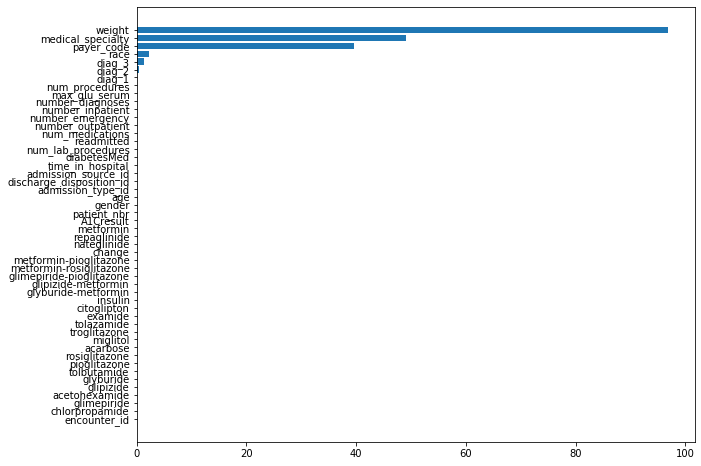

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
missing = pd.DataFrame({'column':df.columns ,'na_percent':df.isnull().sum()/len(df)*100})
missing.sort_values('na_percent',inplace=True)
plt.barh(missing['column'],width=missing['na_percent'])
plt.show()

In [6]:
len(df[df['gender']=='Unknown/Invalid'])

3

In [7]:
#dropping columns with high percentage of missing values
df.drop(['weight','medical_specialty','payer_code'],axis=1,inplace=True)
# Replace uninformative gender with missing value
df.loc[df['gender'] == 'Unknown/Invalid', 'gender'] = np.nan
# dropping all records which contain NaN
df.dropna(inplace=True)
df.isna().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol  

In [8]:
df.shape

(98052, 47)

In [9]:
df['patient_nbr'].nunique()

68629

In [10]:
df['patient_nbr'].value_counts()

88785891     39
1660293      23
88227540     23
23199021     23
84428613     22
             ..
36674964      1
106407315     1
78154461      1
5461389       1
93251151      1
Name: patient_nbr, Length: 68629, dtype: int64

From the paper: "The preliminary dataset contained multiple inpatient
visits for some patients and the observations could not
be considered as statistically independent, an assumption
of the logistic regression model. We thus used only one
encounter per patient; in particular, we considered only the
first encounter for each patient as the primary admission and
determined whether or not they were readmitted within 30
days."

This would be an issue for logistic our regression. Hence, we drop all the repeated occurrences of patients to make the data i.i.d.  

In [11]:
# Keep only the first encounter of each patient
df['total_admissions'] = df.groupby('patient_nbr').cumcount()
df = df.drop_duplicates(subset= ['patient_nbr'], keep = 'last')
# Drop encounter_id and patient_nbr
df.drop(['encounter_id','patient_nbr'],axis=1,inplace=True)

At this point of time, the dataset seemed to be ready for one-hot encoding. But applying it produced ~2350 columns. We need a further look into each of the columns.

In [12]:
for col in df.columns:
    print(col,df[col].unique())

race ['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic']
gender ['Female' 'Male']
age ['[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)' '[70-80)'
 '[80-90)' '[90-100)' '[0-10)']
admission_type_id [1 2 3 6 4 5 8 7]
discharge_disposition_id [ 1  3  6  2  5 11 25 10  7 14  4 18  8 13 12 22 17 23  9 16 20 15 28 24
 19 27]
admission_source_id [ 7  2  4  1  6 20  5  3 17  8  9 14 10 22 11 25 13]
time_in_hospital [ 3  2  1  4  5 13 12  9  7 10 11  6  8 14]
num_lab_procedures [ 59  11  44  51  31  70  73  68  33  47  62  55  49  75  45  29  35  42
  19  64  52  87  53  46  28  36  48  72  10   2  65  67  58  37  57  25
  34  39  69  38  27  56  22  96  78  61  60  66  43   1  18  41  82  54
   9  24  71  63  77  50  81  93  76 103  80  90  16  32  12  30  17  21
  79  26  95  97  14  74  23  13  40 105  86  83  84  98  20   5  85   6
  94   8 102 100  15  88  91  92   4  89 101   3  99   7 114 111 129 107
 108 106 109 120 113 104 121 126 118]
num_procedures [0 5 1 6 2 3 4]
nu

This is mainly because of 3 columns, diag_1, diag_2 and diag_3 with 848, 923 and 954 unique values respectively. A lot of these values can be grouped into the same classes.

In [13]:
diag_cols = ['diag_1','diag_2','diag_3']
for col in diag_cols:
    df[col] = df[col].str.replace('E','-')
    df[col] = df[col].str.replace('V','-')
    condition = df[col].str.contains('250', na=False)
    df.loc[condition,col] = '250'

df[diag_cols] = df[diag_cols].astype(float)

In [14]:
# diagnosis grouping based on ICD9 codes given in the paper
for col in diag_cols:
    df['temp']='Others'
    df.loc[df[col]==250,'temp']='Diabetes'
    df.loc[(df[col]>=390) & (df[col]<=458) | (df[col]==785),'temp']='Circulatory'
    df.loc[(df[col]>=460) & (df[col]<=519) | (df[col]==786),'temp']='Respiratory' 
    df.loc[(df[col]>=520) & (df[col]<=579) | (df[col]==787),'temp']='Digestive'
    df.loc[(df[col]>=580) & (df[col]<=629) | (df[col]==788),'temp']='Genitourinary'
    df.loc[(df[col]>=800) & (df[col]<=999),'temp']='Injury'
    df.loc[(df[col]>=710) & (df[col]<=739),'temp']='Muscoloskeletal'
    df.loc[(df[col]>=140) & (df[col]<=239),'temp']='Neoplasms'
    df.loc[df[col]<0,'temp']='External'
    df[col]=df['temp']
    df.drop('temp',axis=1,inplace=True)
for col in diag_cols:
    print(col,df[col].unique())

diag_1 ['Others' 'Neoplasms' 'Circulatory' 'Diabetes' 'Respiratory' 'Injury'
 'External' 'Genitourinary' 'Muscoloskeletal' 'Digestive']
diag_2 ['Diabetes' 'Neoplasms' 'Circulatory' 'Respiratory' 'Others' 'Injury'
 'Muscoloskeletal' 'Genitourinary' 'Digestive' 'External']
diag_3 ['Others' 'External' 'Circulatory' 'Diabetes' 'Respiratory' 'Injury'
 'Neoplasms' 'Genitourinary' 'Digestive' 'Muscoloskeletal']


In [15]:
for col in diag_cols:
    print(df[col].value_counts())
    print("----------------------")

Circulatory        20641
Others             11210
Respiratory         9544
Digestive           6382
Diabetes            5077
Injury              4765
Muscoloskeletal     3707
Genitourinary       3520
Neoplasms           2624
External            1159
Name: diag_1, dtype: int64
----------------------
Circulatory        21655
Others             16084
Diabetes            8457
Respiratory         7306
Genitourinary       5629
Digestive           2839
External            1833
Neoplasms           1783
Injury              1773
Muscoloskeletal     1270
Name: diag_2, dtype: int64
----------------------
Circulatory        20774
Others             16658
Diabetes           11892
Respiratory         4810
Genitourinary       4260
External            3518
Digestive           2620
Injury              1404
Muscoloskeletal     1352
Neoplasms           1341
Name: diag_3, dtype: int64
----------------------


In [16]:
df['age'] = df['age'].str[1:].str.split('-',expand=True)[0]
df['age'] = df['age'].astype(int)
max_glu_serum_dict = {'None':-100,
                      'Norm':0,
                      '>200':1,
                      '>300':1
                     }
df['max_glu_serum_abnormal'] = df['max_glu_serum'].replace(max_glu_serum_dict)
df.drop('max_glu_serum',axis=1,inplace=True)

A1Cresult_dict = {'None':-100,
                  'Norm':0,
                  '>7':1,
                  '>8':1
                 }
df['A1CresultAbnormal'] = df['A1Cresult'].replace(A1Cresult_dict)
df.drop('A1Cresult',axis=1,inplace=True)

change_dict = {'No':0,
               'Ch':1
              }
df['change'] = df['change'].replace(change_dict)

diabetesMed_dict = {'No':0,
                    'Yes':1
                   }
df['diabetesMed'] = df['diabetesMed'].replace(diabetesMed_dict)

df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,total_admissions,max_glu_serum_abnormal,A1CresultAbnormal
1,Caucasian,Female,10,1,1,7,3,59,0,18,...,No,No,No,No,1,1,>30,0,-100,-100
2,AfricanAmerican,Female,20,1,1,7,2,11,5,13,...,No,No,No,No,0,1,NO,0,-100,-100
3,Caucasian,Male,30,1,1,7,2,44,1,16,...,No,No,No,No,1,1,NO,0,-100,-100
4,Caucasian,Male,40,1,1,7,1,51,0,8,...,No,No,No,No,1,1,NO,0,-100,-100
5,Caucasian,Male,50,2,1,2,3,31,6,16,...,No,No,No,No,0,1,>30,0,-100,-100


In [17]:
d24_feature_dict = {'Up':10,
                    'Down':-10,
                    'Steady':0,
                    'No':-200
                   }
d24_cols = ['metformin','repaglinide','nateglinide','chlorpropamide',
 'glimepiride','acetohexamide','glipizide','glyburide',
 'tolbutamide','pioglitazone','rosiglitazone','acarbose',
 'miglitol','troglitazone','tolazamide','examide',
 'citoglipton','insulin','glyburide-metformin','glipizide-metformin',
 'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']

for col in d24_cols:
    colname = str(col) + 'temp'
    df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
df['medication_changes'] = 0
for col in d24_cols:
    colname = str(col) + 'temp'
    df['medication_changes'] = df['medication_changes'] + df[colname]
    del df[colname]

for col in d24_cols:
    df[col] = df[col].replace(d24_feature_dict)

df['within30'] = np.where(df['readmitted']=='<30',1,0)
df['readmitted'] = np.where(df['readmitted']=='NO',0,1)

df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,total_admissions,max_glu_serum_abnormal,A1CresultAbnormal,medication_changes,within30
1,Caucasian,Female,10,1,1,7,3,59,0,18,...,-200,-200,1,1,1,0,-100,-100,1,0
2,AfricanAmerican,Female,20,1,1,7,2,11,5,13,...,-200,-200,0,1,0,0,-100,-100,0,0
3,Caucasian,Male,30,1,1,7,2,44,1,16,...,-200,-200,1,1,0,0,-100,-100,1,0
4,Caucasian,Male,40,1,1,7,1,51,0,8,...,-200,-200,1,1,0,0,-100,-100,0,0
5,Caucasian,Male,50,2,1,2,3,31,6,16,...,-200,-200,0,1,1,0,-100,-100,0,0


In [18]:
# 11,19,20,21 represent the patient expired at hospital or at home. We should remove these from our dataset as they cannot be 
# readmitted.
df = df[~df['discharge_disposition_id'].isin([11,19,20,21])]
df['discharge_disposition_id'].value_counts()

1     41323
3      8987
6      8253
18     2348
2      1401
22     1267
5       794
25      536
4       506
7       388
13      357
14      346
23      272
28       77
8        69
15       30
24       29
9        12
17       11
10        6
16        5
27        4
12        2
Name: discharge_disposition_id, dtype: int64

In [20]:
df.isna().sum()

race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide                  0
examide                     0
citoglipto

In [21]:
cat_data = ["race","gender","diag_1","diag_2","diag_3",
 "admission_type_id","discharge_disposition_id","admission_source_id"]
for col in cat_data:
    df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col],prefix=col)], axis=1)
df.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,...,admission_source_id_8,admission_source_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_20,admission_source_id_22,admission_source_id_25
1,10,3,59,0,18,0,0,0,9,-200,...,0,0,0,0,0,0,0,0,0,0
2,20,2,11,5,13,2,0,1,6,-200,...,0,0,0,0,0,0,0,0,0,0
3,30,2,44,1,16,0,0,0,7,-200,...,0,0,0,0,0,0,0,0,0,0
4,40,1,51,0,8,0,0,0,5,-200,...,0,0,0,0,0,0,0,0,0,0
5,50,3,31,6,16,0,0,0,9,-200,...,0,0,0,0,0,0,0,0,0,0


In [22]:
df.reset_index(inplace=True,drop=True)
df.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,...,admission_source_id_8,admission_source_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_20,admission_source_id_22,admission_source_id_25
0,10,3,59,0,18,0,0,0,9,-200,...,0,0,0,0,0,0,0,0,0,0
1,20,2,11,5,13,2,0,1,6,-200,...,0,0,0,0,0,0,0,0,0,0
2,30,2,44,1,16,0,0,0,7,-200,...,0,0,0,0,0,0,0,0,0,0
3,40,1,51,0,8,0,0,0,5,-200,...,0,0,0,0,0,0,0,0,0,0
4,50,3,31,6,16,0,0,0,9,-200,...,0,0,0,0,0,0,0,0,0,0


In [23]:
df["readmitted"].value_counts()

0    50258
1    16765
Name: readmitted, dtype: int64

In [24]:
df['within30'].value_counts()

0    63859
1     3164
Name: within30, dtype: int64

In [25]:
df.shape

(67023, 125)

In [26]:
df.to_csv("Clean_Data.csv",index=False)